# 3. Feature Engineering, Extraction and Selection

This section is dedicated to the feature analysis: I am going to apply lemmatizing, encoding and vectorization in order to obtain a sparse matrix of words along with a numerical target variable. This is essential to run the models.

## Inporting Dependencies

In [64]:
import matplotlib.pyplot as plt
from matplotlib import style
from datetime import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import json
import re
import nltk
from nltk.stem  import WordNetLemmatizer
from prettytable import PrettyTable
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import chi2

import warnings
warnings.filterwarnings('ignore')

In [65]:
# nltk.download('punkt')
# nltk.download('averaged_perceptron_tagger')
# nltk.download('maxent_ne_chunker')
# nltk.download('words')
# nltk.download("stopwords")
# nltk.download('tagsets')
# nltk.download('vader_lexicon')
# nltk.download('wordnet')

In [66]:
plt.style.use('ggplot')

In [67]:
df = pd.read_csv('G:/Il mio Drive/MAGISTRALE/IT Coding/Project/Sentiment-Analysis-on-Amazon-product-reviews/Data/after_EDA_revs.csv')
df.drop(columns='Unnamed: 0', inplace=True)
df.head(3)

,Clean Review,Review,Title,Content,Rating,Sentiment,Year,Month,Day,TB Polarity,Review Length,Word Count
0,good sound seem decent build quality good soun...,good sound. seem decent build quality and good...,good sound,seem decent build quality and good sound. very...,5,Positive,2023,5,28,0.561111,79,13
1,not realise bad audio setup considering used q...,i didn't realise how bad my audio setup was. c...,i didn't realise how bad my audio setup was,considering i used to have quite a respectable...,5,Positive,2023,5,27,0.256481,521,94
2,beauty love compact shape sound,its a beauty. love its compact shape and sound,its a beauty,love its compact shape and sound,5,Positive,2023,5,26,0.450000,46,9


## Feature Engineering

- Lemmatize all clean reviews
- Encoding sentiment's labels
- Word Embedding using TD-IDF Vectorizer
- SMOTE for sample imbalance

### Lemmatization

In this part I am going to define a function which will **lemmatize** all the words in the sentences of the 'Clean Review' column. 

But what does lemmatize mean? A lemma is a word that represents a whole group of words, so lemmatizing consists in reducing  words to their core meaning (doing -> do). Lemmatization generally has higher accuracy than another technique called Stemming. Lemmatization is preferred for context analysis, whereas stemming is recommended when the context is not important. Stemming is the process of reducing the inflected form of a word to its root form.

For this function I firstly used nltk word_toknenize() and pos_tag() methods to split the sentence in a list words (a.k.a. feature vector) with their respective tag. Then I proceeded to check which words the WordNetLemmatizer() could lemmatize (adjectives, nouns, adverbs and verbs), lemmatizing the words in the sentence based on their POS tags and returning the list of lemmatized words. To do that I extracted the first letter of the tag and converted it to lower case in order to use that variable in the lemmatizer.

POS tags: 
- "a" refers to adjectives
- "r" refers to adverbs
- "n" refers to nouns
- "v" refers to verbs

In [68]:
# here we can find the meaning of all the tags
# nltk.help.upenn_tagset()

In [69]:
def lemmatize(sentence):
    lemmatizer = WordNetLemmatizer()                                # define the lemmatizer

    tokens = nltk.word_tokenize(sentence)                           # tokenize sentence
    tags = nltk.pos_tag(tokens)                                     # tag each token
    list_of_tags = ['JJ', 'JJR', 'JJS',                             # adjectives
                    'NN', 'NNP', 'NNPS', 'NNS',                     # nouns
                    'RB', 'RBR', 'RBS',                             # adverbs
                    'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']        # verbs

    lemmatized_sentence = ""
    for t in tags:
        if t[1] in list_of_tags:
            pos = t[1].lower()[0]
            if t[1][0] == 'J':
                pos = 'a'                                           # according to the 4 different pos values
        else:
            pos = None      # invariant words

        if pos != None:
            lemma = lemmatizer.lemmatize(t[0], pos=pos)
        else:
            lemma = t[0]
        lemmatized_sentence += " " + lemma                           # build the lemmatized sentence
    return lemmatized_sentence

In [70]:
df['Clean Review'] = df['Clean Review'].apply(lemmatize)
df.head(3)

,Clean Review,Review,Title,Content,Rating,Sentiment,Year,Month,Day,TB Polarity,Review Length,Word Count
0,good sound seem decent build quality good sou...,good sound. seem decent build quality and good...,good sound,seem decent build quality and good sound. very...,5,Positive,2023,5,28,0.561111,79,13
1,not realise bad audio setup consider use quit...,i didn't realise how bad my audio setup was. c...,i didn't realise how bad my audio setup was,considering i used to have quite a respectable...,5,Positive,2023,5,27,0.256481,521,94
2,beauty love compact shape sound,its a beauty. love its compact shape and sound,its a beauty,love its compact shape and sound,5,Positive,2023,5,26,0.450000,46,9


### Encoding sentiment's labels

Here I'm using the label encoder to convert the values (Positive, Negative, Neutral) of the Sentiment Feature into numbers.

In [71]:
encoder = LabelEncoder()

In [72]:
df['Target'] = encoder.fit_transform(df['Sentiment'])
df['Target'].unique()

array([2, 0, 1])

- 2 is Positive
- 1 is Neutral
- 0 is Negative

In [73]:
y = df['Target']
y.value_counts()

2    643
0     66
1     31
Name: Target, dtype: int64

As we already know from the EDA, there is a huge class imbalance in the Target variable. Therefore, after the Word Embedding stage, we can use a little "trick" to re-balance the classes (SMOTE).

### TD-IDF 

The aim of this section is to embed the words in each corpus. In very simple terms, **Word Embeddings** are the texts converted into numbers and there may be different numerical representations of the same text. In fact there are different types of word embeddings - One Hot Encoding, the CountVectorizer, Bag Of Words (BOW), N-grams and TD-IDF vectorization - and in this case I am going to use the TD-IDF one.

Term Frequency - Inverse Document Frequency (TF-IDF) gives a measure that takes the importance of a word into consideration depending on how frequently it occurs in a document and a corpus. The formula for finding TF-IDF is the following:
$$W_{x,y} = tf_{x,y}log(\frac{N}{df_{x}})$$
Where:
- W is the word x within the review y
- tf is the term frequency of x in y
- df is the number of reviews containing x
- N is the total number of reviews

This section is really important since it is here where the real data preparation for the models happens:
1. Splitting the data into train and test (will use cross-validation for model evaluation)
2. Creating the TF-IDF Vectorizer object
3. Use the vectorizer to fit AND transform: this method will analyze the text data in the **train set**, learn the vocabulary, and compute the TF-IDF scores for each review. Note that for the test I used only the transform method, transforming the 'Clean Review' column of the test data into a sparse matrix **using the same TF-IDF features learned from the training data**.

In [74]:
data = df[['Clean Review', 'Sentiment', 'Target']]

In [75]:
train, test = train_test_split(data,test_size=.2,random_state=42, shuffle=True)

In [76]:
tfidf = TfidfVectorizer(analyzer = "word", ngram_range=(1,3), max_features=5000)
# I want the vectorizer to analyze words, unigrams-bigrams and trigrams, and at most 5000 n-grams

In [77]:
X_train = tfidf.fit_transform(train['Clean Review']).toarray()
X_test = tfidf.transform(test['Clean Review']).toarray()

y_train = train['Target']
y_test = test['Target']

In [78]:
print(f'Train set shape: {X_train.shape}')
print(f'Test set shape: {X_test.shape}')

Train set shape: (592, 5000)
Test set shape: (148, 5000)


We obtained two sparse matrices with 10000 features, as we wanted. Basically these are matrices where every column is a n-gram and the values are the "impact" that each particular n-gram has on the entire review. Let's visualize the features and the matrix.

In [79]:
print(f'The first 10 features/n-grams of the sparse matrix are: {tfidf.get_feature_names()[:10]}')
print(f'The last 10 features/n-grams of the sparse matrix are: {tfidf.get_feature_names()[-10:]}')

The first 10 features/n-grams of the sparse matrix are: ['10', '10 10', '10 10 10', '10 15', '10 year', '100', '100 recommend', '12', '12 month', '14']
The last 10 features/n-grams of the sparse matrix are: ['year use', 'yes', 'yes speaker', 'yet', 'yet sound', 'youre', 'youtube', 'youtube review', 'z506', 'zero']


In [80]:
print(X_train)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


---

### Visualizing the sparse matrix

Here a small curiosity I had: I have now a high dimensional sparse matrix and it could be fun if I could visualize it in 2 dimensions. I recently had huge interest and the opportunity to analyze different dimensionality reduction techniques in terms of preservation of global variance and in terms of visualization.

From the sklearn's documentation: It is highly recommended to use another dimensionality reduction method (e.g. PCA for dense data or TruncatedSVD for sparse data) to reduce the number of dimensions to a reasonable amount (e.g. 50) if the number of features is very high. This will suppress some noise and speed up the computation of pairwise distances between samples.

Also coming from the sklearn's documentation of TruncatedSVD: "TruncatedSVD works on term count/tf-idf matrices as returned by the vectorizers. In text context, it is known as Latent Semantic Analysis." which is exactly our use case.

Sklearn proposes PCA for dense matrices and TruncatedSVD (which uses singular value decomposition) for sparse matrices. I am also going to try the t-SNE which is generally really good for visualization purposes, but maybe in this case it will not give interesting results. For this analysis I will use only the train set for simplicity.

In [81]:
pca = PCA(n_components=2, random_state=42)
X_embedded_pca = pca.fit_transform(X_train)

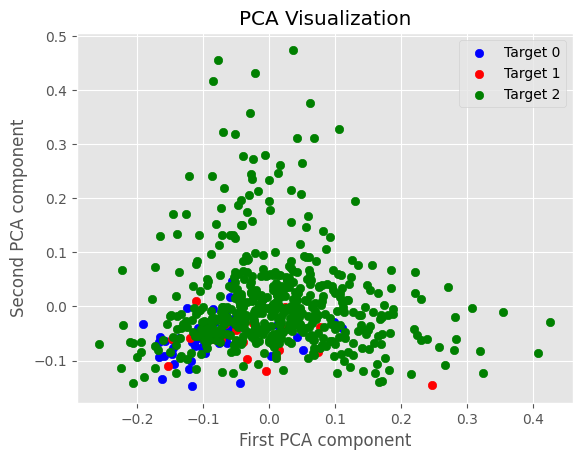

In [82]:
target_colors = ['blue', 'red', 'green']
target_labels = y_train.values

for value in set(target_labels):
    plt.scatter(
        X_embedded_pca[target_labels == value, 0],
        X_embedded_pca[target_labels == value, 1],
        color=target_colors[value],
        label=f"Target {value}"
    )

plt.title("PCA Visualization")
plt.xlabel("First PCA component")
plt.ylabel("Second PCA component")
plt.legend()
plt.show()


In [83]:
svd = TruncatedSVD(n_components=2, random_state=42)
Tsvd = svd.fit_transform(X_train)

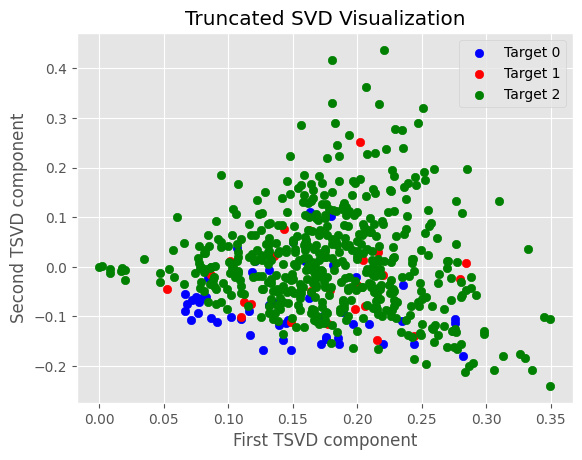

In [84]:
target_colors = ['blue', 'red', 'green']
target_labels = y_train.values

for value in set(target_labels):
    plt.scatter(
        Tsvd[target_labels == value, 0],
        Tsvd[target_labels == value, 1],
        color=target_colors[value],
        label=f"Target {value}"
    )

plt.title("Truncated SVD Visualization")
plt.xlabel("First TSVD component")
plt.ylabel("Second TSVD component")
plt.legend()
plt.show()

In [85]:
tsne = TSNE(n_components=2, random_state=42)
embedded_tsne = tsne.fit_transform(X_train)

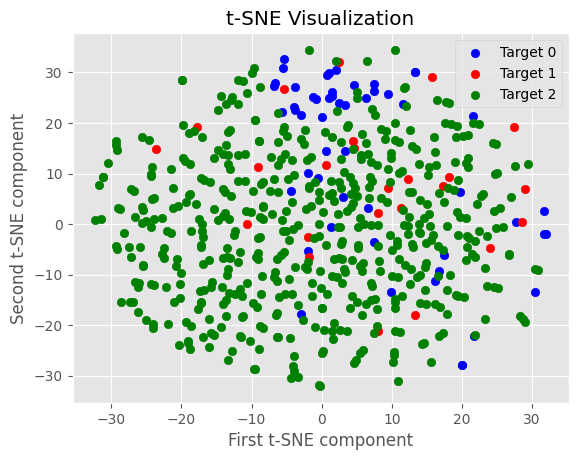

In [86]:
target_colors = ['blue', 'red', 'green']
target_labels = y_train.values

for value in set(target_labels):
    plt.scatter(
        embedded_tsne[target_labels == value, 1],
        embedded_tsne[target_labels == value, 0],
        color=target_colors[value],
        label=f"Target {value}"
    )

plt.title("t-SNE Visualization")
plt.xlabel("First t-SNE component")
plt.ylabel("Second t-SNE component")
plt.legend()
plt.show()

In [87]:
tsne = TSNE(n_components=3, random_state=42)
embedded_tsne = tsne.fit_transform(X_train)

In [88]:
plt.style.use('default')

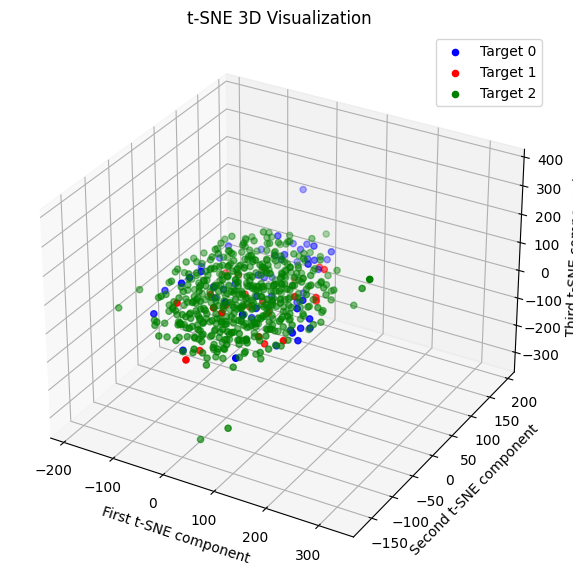

In [89]:
target_colors = ['blue', 'red', 'green']
target_labels = y_train.values

fig = plt.figure(figsize=(9,7))
ax = fig.add_subplot(111, projection='3d')
for value in set(target_labels):
    ax.scatter(
        embedded_tsne[target_labels == value, 0],
        embedded_tsne[target_labels == value, 1],
        embedded_tsne[target_labels == value, 2],
        color=target_colors[value],
        label=f"Target {value}"
    )

ax.set_title("t-SNE 3D Visualization")
ax.set_xlabel("First t-SNE component")
ax.set_ylabel("Second t-SNE component")
ax.set_zlabel("Third t-SNE component")
ax.legend()
plt.show()

Unfortunately we can't draw some interesting insights, but it was expected from looking at the wordclouds for instance (they were all pretty similar). But for sure, we can say that the all reviews are pretty much aggregated in a single big cluster with some positive reviews outliers. The class imbalance is again clear.

In [90]:
plt.style.use('ggplot')

---
### SMOTE

It could be important to balance the classes in such situation. Here I use SMOTE (Synthetic Minority Oversampling Technique) to solve this problem. It aims to balance class distribution by randomly increasing minority class examples by replicating them.

SMOTE synthesises new minority instances between existing minority instances: in simple words, it basically generates new synthetic training records by randomly selecting one or more of the k-nearest neighbors for each example in the minority class.

In [91]:
y.value_counts()

2    643
0     66
1     31
Name: Target, dtype: int64

In [92]:
y_train.value_counts()

2    515
0     53
1     24
Name: Target, dtype: int64

Showing again the class imbalance for completeness.

In [93]:
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

print(f'After SMOTE, the shape of Target is: {Counter(y_train)}')

After SMOTE, the shape of Target is: Counter({2: 515, 1: 515, 0: 515})


In [94]:
print(f'The resampled sparse matrix has now dimension: {X_train.shape}')
print(f'The resampled target feature vector has now length: {len(y_train)}')

The resampled sparse matrix has now dimension: (1545, 5000)
The resampled target feature vector has now length: 1545


For obvious reasons, I have only balanced the train set.

---

## Feature Extraction and Selection

The sparse matrices are really large, and since we are working on a Classification task we could extract and select the most important/impactful n-grams to simplify the training the models for example by using a chi-square test. But I decided to not perform this for 2 reasons: firstly the 5000 number was an arbitrary decision I could simply reduce if I wanted less features, and secondly I did some tests plotting the feature importances after implementing a simple Random Forest Classifier and I noticed that the feature importance rates were really low also fot the best ones.

Let's jump into the models.